In [2]:
import torch
import torch.backends.cudnn as cudnn
from torchvision import models
from data_aug.contrastive_learning_dataset import ContrastiveLearningDataset
from models.resnet_simclr import ResNetSimCLR
from simclr import SimCLR

In [32]:
dataset = ContrastiveLearningDataset("./datasets")
train_dataset = dataset.get_dataset("stl10", 2)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True, pin_memory=True, drop_last=True)

Files already downloaded and verified


torch.Size([3, 96, 96])
torch.Size([3, 96, 96])
-1


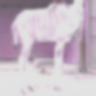

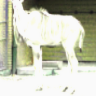

In [34]:
# 同一张图像经过两次随机的数据增强得到的正样本对
print(train_dataset[0][0][0].shape)
print(train_dataset[0][0][1].shape)
# unlabeled数据，label无意义
print(train_dataset[0][1])

from torchvision.transforms.functional import to_pil_image
from IPython.display import display
# 调整张量维度以符合 matplotlib 的期望格式：[高度, 宽度, 通道数]
image_pil = to_pil_image(train_dataset[0][0][0])
display(image_pil)
image_pil = to_pil_image(train_dataset[0][0][1])
display(image_pil)

In [ ]:
model = ResNetSimCLR(base_model="resnet18", out_dim=128)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader), eta_min=0, last_epoch=-1)

gpu_index = 0
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    gpu_index = -1
#  It’s a no-op if the 'gpu_index' argument is a negative integer or None.
with torch.cuda.device(gpu_index):
    simclr = SimCLR(model=model, optimizer=optimizer, scheduler=scheduler, args=args)
    simclr.train(train_loader)